In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, sys, re
from glob import glob
import subprocess

from collections import Counter
from itertools import chain
from functools import partial

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

## Load Data
Files to load: all (`os.listdir` with model specified) vs specific list

Note: `reference` might also contain non test files - filter out

In [12]:
def name_adapt(s:str, extra_patterns:list=[]):
    extra_patterns += ['finetuned', '.csv']
    for p in extra_patterns:
        s = s.replace(p,'')
    # replace adjacent '-' / '_' with only one
    return re.sub('[-_]{1,}','-',s).split('/')[-1]


In [28]:
dataset = "paco-cheese"
data_folder = f"../data/{dataset}/*/*.csv"
gf_reference = "gpt2-fr-training_file_1024.csv"
model_patterns = ['rnn', 'gpt','srilm']
data_paths = {
    ("reference" if gf_reference in x else name_adapt(x,[dataset])):x for x in glob(data_folder) if any([y in x.lower() for y in model_patterns]) 
            and ('_old' not in x) and ('res_fft' not in x) # os.listdir(data_folder)
}

In [29]:
gpt_ctx_nopivot = [k for k,v in data_paths.items() if 'c0-8.csv' in v]
gpt_c08l = {}
for k in gpt_ctx_nopivot:
    gpt_c08l[k] = pd.read_csv(data_paths.pop(k))
print(gpt_c08l.keys())
data_paths

dict_keys(['rnn-ft-pc2-c0-8', 'gpt2-fr-space-c0-8', 'gpt2-fr-eos-c0-8'])


{'rnn-ft-pc2-': '../data/paco-cheese/res_rnn/rnn_ft_pc2-paco-cheese.csv',
 'rnn-ft-pc2-c0-8-p': '../data/paco-cheese/res_rnn/rnn_ft_pc2-paco-cheese-c0-8-p.csv',
 'gpt2-fr-eos-c0-8-p': '../data/paco-cheese/res_gpt2-fr/gpt2-fr-paco-cheese-finetuned-paco-cheese-eos-c0-8-p.csv',
 'gpt2-fr-space-c0-8-p': '../data/paco-cheese/res_gpt2-fr/gpt2-fr-paco-cheese-finetuned-paco-cheese-space-c0-8-p.csv',
 'gpt2-fr-sep': '../data/paco-cheese/res_gpt2-fr/gpt2-fr-paco-cheese-finetuned-paco-cheese-sep.csv',
 'gpt2-fr-fin': '../data/paco-cheese/res_gpt2-fr/gpt2-fr-paco-cheese-finetuned-paco-cheese-fin.csv',
 '-test-srilm-LM-FR-pretrain': '../data/paco-cheese/res_srilm/paco-cheese-test_srilm-LM_FR_pretrain.csv',
 '-test-srilm-LM-FR-pret-orfeocid': '../data/paco-cheese/res_srilm/paco-cheese-test_srilm-LM_FR_pret_orfeocid.csv',
 '-test-srilm-LM-FR-nopretrain': '../data/paco-cheese/res_srilm/paco-cheese-test_srilm-LM_FR_nopretrain.csv',
 '-test-srilm-LM-FR-orfeocid': '../data/paco-cheese/res_srilm/paco-chee

In [30]:
df = {}
srilm_cols = ['test_text','sent_index','nb_oov','pred_tokens','sum_logp','perplexity','perplexity_no-eos']
for k,v in data_paths.items():
    tmp = pd.read_csv(v)
    model_pat = [y for y in model_patterns if y in v.lower()][0] # necessarily not empty bc of prev selection
    if 'model' not in tmp.columns: # typically: reference
        tmp['model'] = k
    else: # adding for _x context, problem when rnn/gpt have both
        tmp['model'] = tmp['model'].apply(lambda x: f'{model_pat}{x}' if model_pat not in x else x)
    
    # specific to srilm models
    if 'srilm' in k:
        tmp['sum_h'] = tmp['sum_logp']
        tmp['tokens'] = tmp['pred_tokens']
        tmp = tmp[[col for col in tmp.columns if col not in srilm_cols]]
    
    df[k] = tmp

res = pd.concat(df.values(), axis=0)

In [31]:
models = res.model.unique()
models

array(['rnn-ft-pc2-', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4',
       'rnn_5', 'rnn_6', 'rnn_7', 'gpt_eos_0', 'gpt_eos_1', 'gpt_eos_2',
       'gpt_eos_3', 'gpt_eos_4', 'gpt_eos_5', 'gpt_eos_6', 'gpt_eos_7',
       'gpt_space_0', 'gpt_space_1', 'gpt_space_2', 'gpt_space_3',
       'gpt_space_4', 'gpt_space_5', 'gpt_space_6', 'gpt_space_7',
       'gpt2-fr-paco-cheese-finetuned-context_full_sep_space',
       'gpt2-fr-paco-cheese-finetuned-context_full_sep_eos',
       'gpt2-fr-fin', 'srilm-LM_FR_pretrain', 'srilm-LM_FR_pret_orfeocid',
       'srilm-LM_FR_nopretrain', 'srilm-LM_FR_orfeocid'], dtype=object)

In [17]:
res_files = Counter(chain(*[res[res.model == model].file.unique() for model in res.model.unique()]))
res_files = [k for k,v in res_files.items() if v == len(models)]
res = res[res.file.isin(res_files)]

In [18]:
res.head()

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,has_theme,context,text_u,normalised_h,length,tokens_h,sum_h,tokens,xu_h,model
0,cheese,Cheese-AA_OR,AAOR,0,AA,4.54,4.83993,tu as,hetero selection,g,...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,tu as,8.153041,2,"[-13.647509574890137, -2.6585729122161865]",16.306082,"['tu', ' as']",1.760955,rnn-ft-pc2-paco-cheese
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,mh ouais si tu veux,4.232637,7,"[-5.078619956970215, -0.055531349033117294, -7...",29.628457,"['m', 'h', ' ou', 'ais', ' si', ' tu', ' veux']",0.727805,rnn-ft-pc2-paco-cheese
2,cheese,Cheese-AA_OR,AAOR,2,OR,6.62,7.00991,frog joke,Lecture frog joke OR,g,...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,frog joke,4.357961,4,"[-9.237699508666992, -4.3238372802734375, -3.0...",17.431843,"['f', 'rog', ' j', 'oke']",0.716032,rnn-ft-pc2-paco-cheese
3,cheese,Cheese-AA_OR,AAOR,3,OR,7.42,10.86995,un jour un ingénieur traversait la rue quand u...,Lecture frog joke OR,g,...,True,<|endoftext|><|endoftext|><|endoftext|><|endof...,un jour un ingénieur traversait la rue quand u...,2.679700,16,"[-4.872067451477051, -1.5964605808258057, -3.7...",42.875201,"['un', ' jour', ' un', ' ingénieur', ' travers...",0.459076,rnn-ft-pc2-paco-cheese
4,cheese,Cheese-AA_OR,AAOR,4,OR,11.36,13.83519,si tu m'embrasses je me transforme en belle pr...,Lecture frog joke OR,g,...,True,<|endoftext|><|endoftext|><|endoftext|>tu as<|...,si tu m'embrasses je me transforme en belle pr...,0.835451,12,"[-2.4998767375946045, -0.5545154213905334, -0....",10.025411,"['si', ' tu', ' m', ""'"", 'embrass', 'es', ' je...",0.141889,rnn-ft-pc2-paco-cheese


In [19]:
res.isna().sum(axis=0)

corpus              0
file                0
dyad                0
index               0
speaker             0
start               0
stop                0
text              288
theme            2496
theme_role      14080
theme_index         0
has_theme           0
context         49608
text_u          49779
normalised_h      516
length              0
tokens_h            0
sum_h             516
tokens              0
xu_h              516
model               0
dtype: int64

In [20]:
res.to_csv(f"../data/{dataset}/all_models.csv", index=False)

In [17]:
length_by_file = res.groupby('file')['index'].max().to_dict()

## Plots

### Checking consistency

In [21]:
reference_name = 'gpt2-fr-paco-cheese-finetuned-context_full_sep_eos'#'reference'#'gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'#'reference'

In [22]:
models = res.model.unique()
merge_cols = ['file', 'index', 'speaker', 'text']
int_cols = ['normalised_h', 'xu_h', 'length']
cols = merge_cols + int_cols
comparison_df = {}
if reference_name in models:
    ref = res[res.model == reference_name][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod'))
        print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
        comparison_df[model] = c
    

Correlation for model rnn-ft-pc2-paco-cheese: normalised_h 0.7668173283581744 - xu_h 0.8401236603587182
Correlation for model rnn_0: normalised_h 0.746287191017914 - xu_h 0.7717168076558852
Correlation for model rnn_1: normalised_h 0.6964491275891913 - xu_h 0.7558953382111392
Correlation for model rnn_2: normalised_h 0.6987753836872403 - xu_h 0.7546266105094556
Correlation for model rnn_3: normalised_h 0.6998784237148071 - xu_h 0.755493660545427
Correlation for model rnn_4: normalised_h 0.6999210718293661 - xu_h 0.755079692020197
Correlation for model rnn_5: normalised_h 0.6999549189032589 - xu_h 0.7548563952595165
Correlation for model rnn_6: normalised_h 0.7000145749115535 - xu_h 0.7546829774597869
Correlation for model rnn_7: normalised_h 0.6998774383960679 - xu_h 0.7546260094734459
Correlation for model gpt_eos_0: normalised_h 0.8440347287678069 - xu_h 0.8493379715748193
Correlation for model gpt_eos_1: normalised_h 0.9557174390903311 - xu_h 0.9489305425265886
Correlation for model

In [23]:
xu_corr_results = {model:{} for model in models}
nh_corr_results = {model:{} for model in models}
for reference_model in models:
    ref = res[res.model == reference_model][cols]
    for model in models:
        c = pd.merge(left=ref, right=res[res.model == model][cols], left_on=merge_cols, right_on=merge_cols, suffixes=('_ref', '_mod')).dropna(axis=0, subset=['xu_h_mod'])
        xu_corr_results[reference_model][model] = c.xu_h_ref.corr(c.xu_h_mod)
        nh_corr_results[reference_model][model] = c.normalised_h_ref.corr(c.normalised_h_mod)

xu_corr_results = pd.DataFrame(xu_corr_results)
nh_corr_results = pd.DataFrame(nh_corr_results)

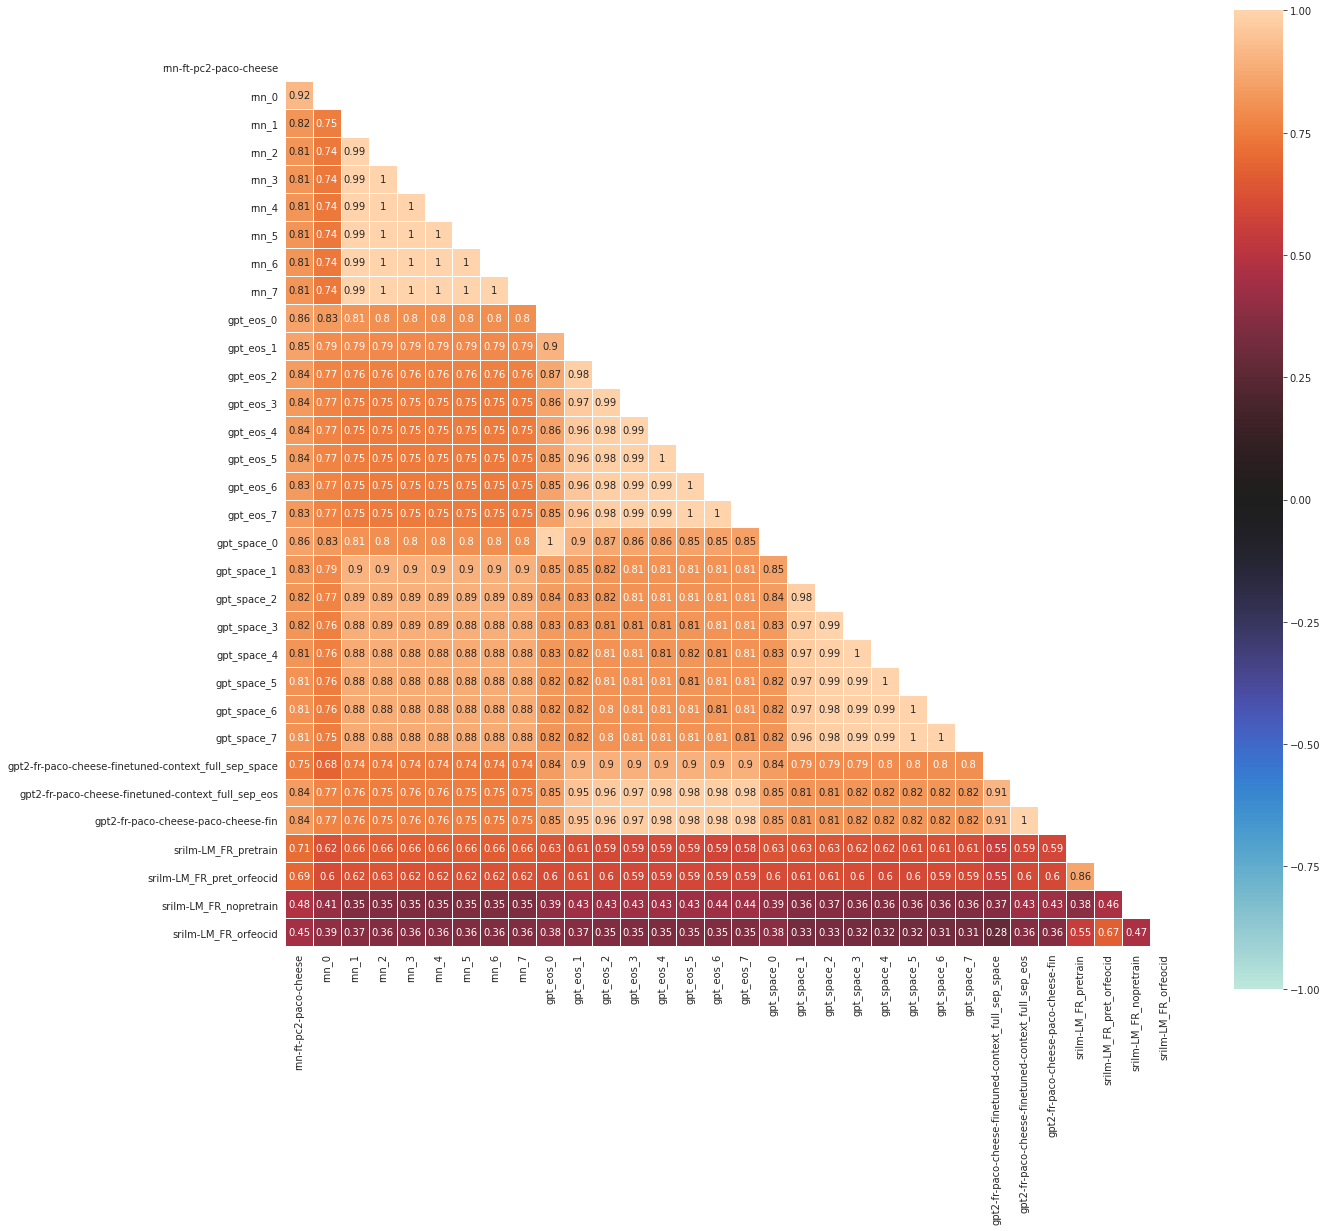

In [24]:
mask = np.zeros_like(xu_corr_results)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(xu_corr_results, mask=mask, vmax=1., vmin=-1., square=True,linewidths=.5,annot=True, center=0)

Setting comparison before going further into analysis of differences:

In [25]:
comparison_name = 'srilm-LM_FR_orfeocid'

Correlation for model srilm-LM_FR_orfeocid: normalised_h 0.3808670254881502 - xu_h 0.3649319224650288


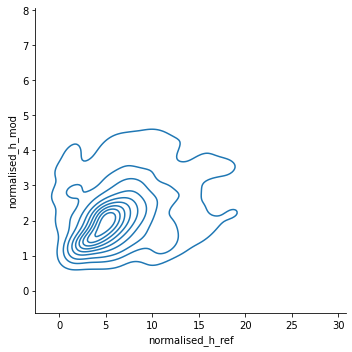

In [26]:
c = comparison_df[comparison_name]
print(f"Correlation for model {model}: normalised_h {c.normalised_h_ref.corr(c.normalised_h_mod)} - xu_h {c.xu_h_ref.corr(c.xu_h_mod)}")
sns.displot(data=c, x="normalised_h_ref", y="normalised_h_mod", kind="kde")

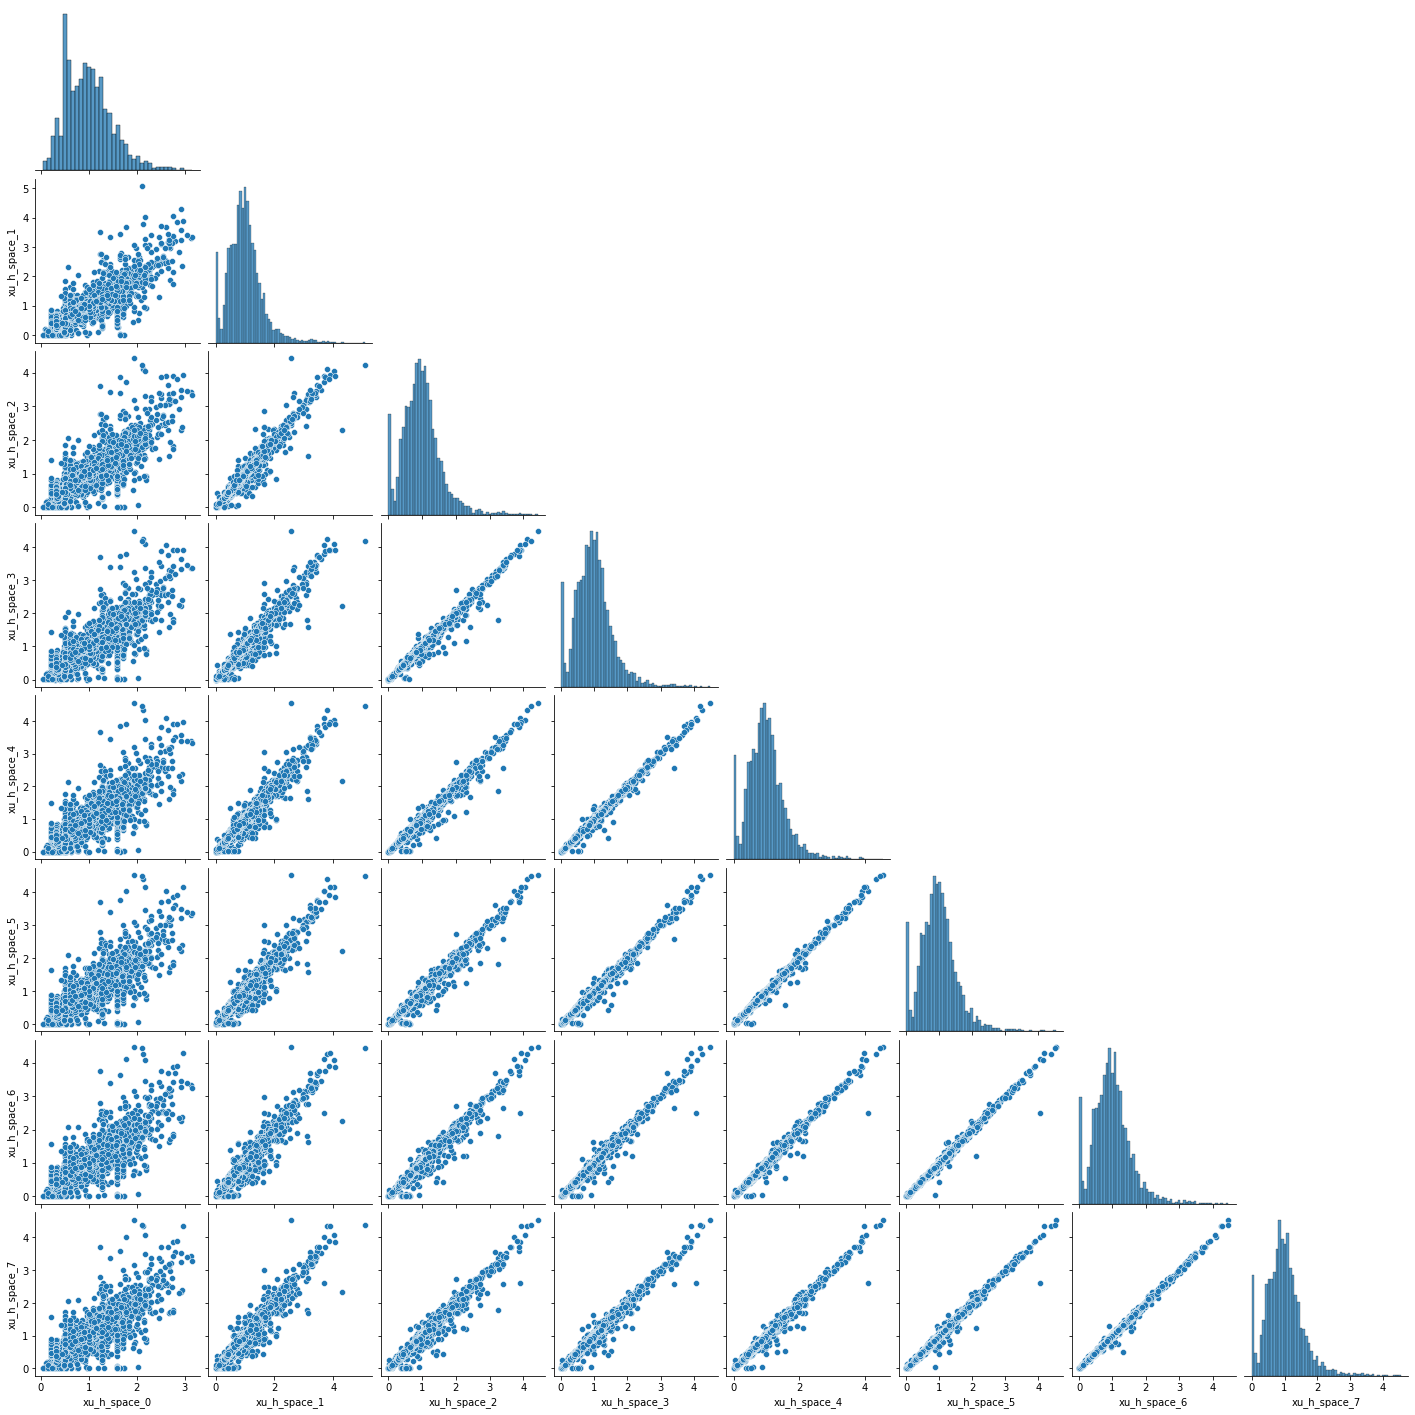

In [35]:
sns.pairplot(gpt_c08l['gpt2-fr-space-c0-8'], vars = [f'xu_h_space_{i}' for i in range(0,8)], corner=True)
plt.show()

### Generals

In [36]:
# keep for study
dialogs = res[res.model.isin([reference_name, comparison_name])]

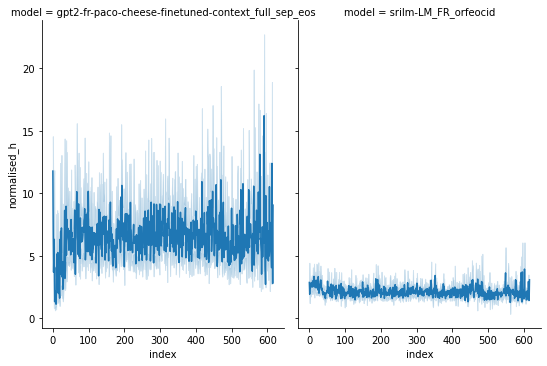

In [37]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h", col='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

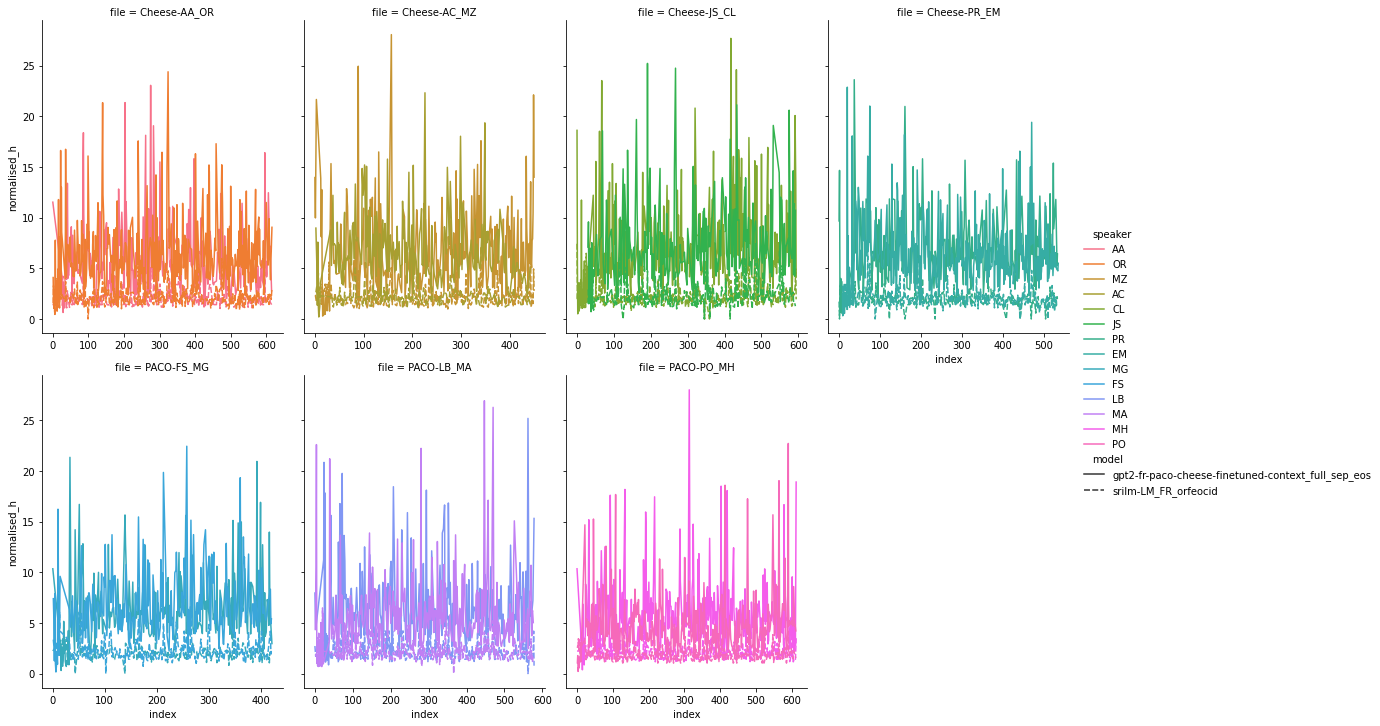

In [38]:
sns.relplot(
    data=dialogs,
    x="index", y="normalised_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

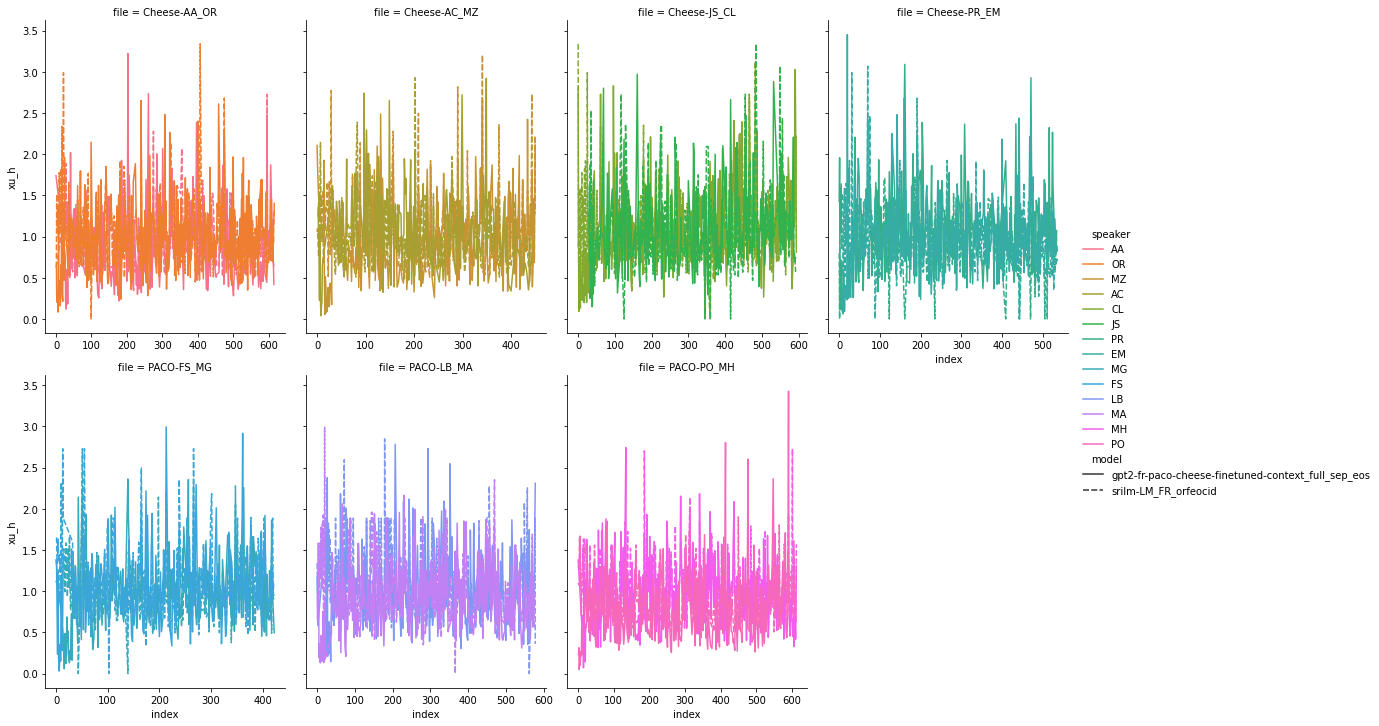

In [39]:
sns.relplot(
    data=dialogs,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

### By episodes

Number of themes by file?

<AxesSubplot:ylabel='Density'>

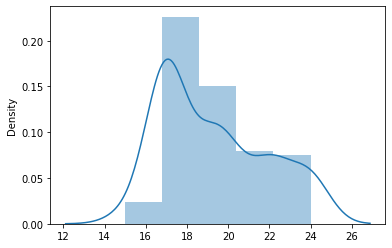

In [40]:
sns.distplot(dialogs.drop_duplicates(subset=['file','theme']).groupby('file').count())

In [41]:
# For the 2nd one: reindex => take the sign * max number
# Remove lines with extra transitions then for each one take the lines before / after and index and concat
# Note: issue with duplicated themes
not_transition = (dialogs.theme != 'transition').astype(int)
#dialogs = dialogs[dialogs.theme != 'transition']
dialogs['theme_index'] = (dialogs.theme != dialogs.theme.shift()).cumsum()
nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(len(x))}).explode('index')['index'].to_list()
inv_nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(-len(x),0)}).explode('index')['index'].to_list()
dialogs['count_after'] = nb_in_ep * not_transition
dialogs['count_before'] =  inv_nb_in_ep * not_transition

In [42]:
def compute_transitions_df(dialogs:pd.DataFrame, min_idx:int=10, max_idx:int=40):
    # TODO: add checks on columns
    # remove_transitions
    dialogs = dialogs[dialogs.theme != 'transition'].reset_index(drop=True)
    # get lines with 0
    new_themes = dialogs[dialogs.count_after == 0]
    new_themes['theme_index'] = range(new_themes.shape[0])

    final_df = []
    for idx, row in new_themes.iterrows():
        tmp = dialogs.iloc[max(0,idx-min_idx):min(dialogs.shape[0],idx+max_idx)]
        tmp['index'] = range(max(-min_idx,-idx), min(max_idx,dialogs.shape[0] - idx))
        # no need to check on file / model, done automatically
        tmp['ba'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else x.count_before, axis=1)
        tmp = tmp[tmp['index'] == tmp.ba]
        tmp['theme_index'] = row.theme_index
        # Add for plotting
        tmp['count_after'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else np.nan, axis=1)
        tmp['count_before'] = tmp.apply(lambda x: x.count_before if x['index'] <= 0 else np.nan, axis=1)
        # Add initiator / responder
        tmp['is_initiator'] = (tmp.speaker == row.speaker)
        # Add to df
        final_df.append(tmp)

    final_df = pd.concat(final_df, ignore_index=True)
    final_df['is_initiator'] = final_df.is_initiator.apply(lambda x: x * 'initiator' + (1 - x) * 'responder')
    return final_df

In [43]:
final_df = compute_transitions_df(dialogs, max_idx=10)
final_df.shape

(5229, 25)

In [44]:
target_col = "normalised_h"

Differenciating between initiators and responders 

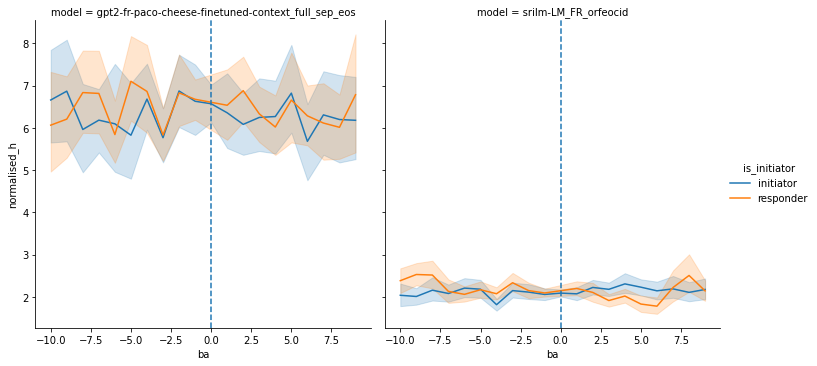

In [45]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Graph we want: apply `statsmodel` _before 0_ and _after 0_ and plot it on the same graph (with a scatterplot for the values)

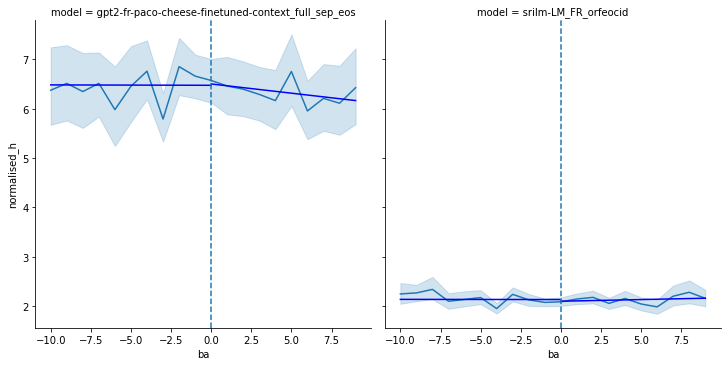

In [46]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model')
model_memory = {model:{} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        tmp = final_df[final_df.model == model].dropna(subset=[col])
        x = np.array([tmp['index'].min(), tmp['index'].max()])
        reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
        #print(model, col, reg_model.params) # .summary() for full summary of model
        g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], 'b')
        model_memory[model][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


In [47]:
target_col = "xu_h"

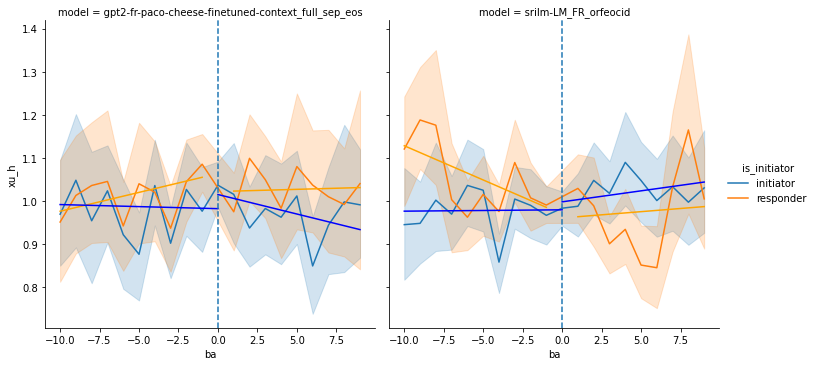

In [48]:
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
model_memory = {model:{spk:{} for spk in ['initiator','responder']} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        for spk, c in zip(['responder', 'initiator'], ['orange', 'b']):
            tmp = final_df[(final_df.model == model) & (final_df.is_initiator == spk)].dropna(subset=[col])
            x = np.array([tmp['index'].min(), tmp['index'].max()])
            reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
            #print(model, col, reg_model.params) # .summary() for full summary of model
            g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], c)
            model_memory[model][spk][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


Investigating a given model:
```python
for spk in ['initiator', 'responder']:
    print(f"\n-------------------{spk.upper()}------------------")
    print(model_memory['gpt_context'][spk]['count_after'].summary())
```

### Data Exploration for one sentence

In [103]:
res[res.text == 'mh ouais si tu veux'][[col for col in res.columns if 'context_' not in col]].head(10)

,corpus,file,dyad,index,speaker,start,stop,text,theme,theme_role,...,has_theme,h,normalised_h,length,tokens_h,tokens,xu_h,model,text_u,sum_h
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,28.442576,4.063225,7,"[-11.516682624816895, -0.17777733504772186, -3...","['m', 'h', 'Ġou', 'ais', 'Ġsi', 'Ġtu', 'Ġveux']",0.864351,reference,NaN,NaN
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.212218,7,"[-11.058761596679688, -2.373636484146118, -3.6...",4.147299,0.646360,gpt_context_0,mh ouais si tu veux,29.485528
3817,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147302,7,"[-10.792609214782715, -0.26334744691848755, -4...",4.147299,0.822468,gpt_context_1,mh ouais si tu veux,29.031112
7633,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147304,7,"[-10.79261589050293, -0.2633468508720398, -4.2...",4.147299,0.842557,gpt_context_2,mh ouais si tu veux,29.031125
11449,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.263347864151001, -4.2...",4.147299,0.844409,gpt_context_3,mh ouais si tu veux,29.031081
15265,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792576789855957, -0.26334843039512634, -4...",4.147299,0.846863,gpt_context_4,mh ouais si tu veux,29.031081
19081,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147301,7,"[-10.792603492736816, -0.26334670186042786, -4...",4.147299,0.847680,gpt_context_5,mh ouais si tu veux,29.031104
22897,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.848037,gpt_context_6,mh ouais si tu veux,29.031096
26713,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147299,7,"[-10.79259204864502, -0.26334816217422485, -4....",4.147299,0.849066,gpt_context_7,mh ouais si tu veux,29.031096
1,cheese,Cheese-AA_OR,AAOR,1,OR,5.14,5.82492,mh ouais si tu veux,hetero selection,f,...,True,NaN,4.147297,7,"[-10.792593002319336, -0.2633475661277771, -4....",4.147297,0.851300,gpt2-fr-paco-cheese-finetuned-context_ 000—bs1,mh ouais si tu veux,29.031082


In [129]:
tmp = comparison_df['gpt2-fr-paco-cheese-finetuned-context_<|endoftext|>000—bs1'].dropna()
tmp['normalised_h_diff'] = (tmp.normalised_h_ref - tmp.normalised_h_mod).abs()/tmp.normalised_h_ref

In [131]:
tmp.sort_values(by='normalised_h_diff', ascending=False).head(20)

,file,index,speaker,text,normalised_h_ref,xu_h_ref,length_ref,normalised_h_mod,xu_h_mod,length_mod,normalised_h_diff
3805,PACO-PO_MH,603,MH,ouais putain,0.000012,0.000002,1,3.075799,0.454410,4,255490.852987
842,Cheese-AC_MZ,225,MZ,ouais c'est des choses différentes quand même ...,0.000044,0.000006,1,4.490942,0.845567,13,103213.062627
2111,Cheese-PR_EM,448,EM,à la fin de la belle au bois dormant enfin de ...,0.000096,0.000013,1,5.653749,1.093170,16,59126.767365
1390,Cheese-JS_CL,322,JS,grave enfin non putain,0.000200,0.000026,1,10.151037,1.523746,5,50797.361249
152,Cheese-AA_OR,152,OR,là c'est loupé genre euh,0.000191,0.000025,1,6.948676,1.238965,9,36302.715022
998,Cheese-AC_MZ,381,MZ,c'est euh,0.000109,0.000014,1,3.498724,0.525184,5,32240.257536
533,Cheese-AA_OR,533,OR,il arrive à m'aligner euh,0.000237,0.000031,1,6.841631,1.156938,8,28828.139415
125,Cheese-AA_OR,125,AA,genre les j'ai vu mes deux résumés je les ai r...,0.000416,0.000055,1,5.373933,0.993172,21,12918.161182
565,Cheese-AA_OR,565,OR,moins que l'année dernière,0.000778,0.000147,2,4.009387,0.740427,6,5155.659811
2143,Cheese-PR_EM,480,EM,tu sais c'était en prévision d'aujourd'hui,0.004278,0.000812,2,6.045893,1.154089,12,1412.167760


## Signal analysis

In [ ]:
model_name = "srilm-LM_EN_pret_swb"
out_file = f"../data/{dataset}/res_fft/{model_name}.csv"
col = "xu_h"
res[res.model == model_name].to_csv(out_file)

cmd = "python ../utils/entropy_spectral.py --data_path "+ out_file +" -dfc \'{\"theme_col\":\"theme_id\"}\' --moves_and_deviation ../../tools/githubs/IT/acl2017-spectral-master/data/moves_and_deviation.csv"
subprocess.check_output(cmd, shell=True)

In [ ]:
[x for x in os.listdir(f"../data/{dataset}/res_fft/") if 'fft' in x]

In [ ]:
file_pat = f"{out_file[:-4]}_REPLACE.csv"
#fft = pd.read_csv(file_pat.replace('REPLACE','_agg0_theme0_fft'))
fft_df = pd.read_csv(file_pat.replace('REPLACE',f'agg0_theme0_{col}_fft'))
fft_df.head()

In [ ]:
g = sns.regplot(data=fft_df[fft_df.speaker == 'g'], x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1})
g = sns.regplot(data=fft_df[fft_df.speaker == 'f'], x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1})
if col == "xu_h":
    g.axes.set_ylim(0,0.6)
else:
    g.axes.set_ylim(0,50)
g

Comparison with random noise

In [ ]:
SPEC_PATH = "/Users/neako/Documents/Cours-MasCo/PhD/tools/githubs/IT/time-series-analysis-master/Python"
sys.path.append(SPEC_PATH)
from spectrum import * # spec_pg

In [ ]:
def compare_with_noise(df:pd.DataFrame, fft_df:pd.DataFrame=None, col_data:str='xu_h', 
        spgram = partial(spec_pgram, taper=0, plot=False, log='no'), n_noise:int=1000 
    ):
    summary = df[col_data].describe()
    print(summary)
    s = np.random.normal(summary['mean'], summary['std'], n_noise)
    s_ent = pd.DataFrame(spgram(s))[['freq','spec']]
    s_ent['origin'] = 'white_noise'

    if fft_df is not None:
        tmp = fft_df[['file','speaker','freq','spec']]
        tmp['origin'] = 'data'
        tmp = pd.concat([tmp,s_ent], axis=0).reset_index(drop=True)
        return tmp
    else:
        return s_ent

In [ ]:
s_ent = compare_with_noise(res[(res.model == 'reference')])
s_ent.head()

In [ ]:
sns.regplot(data=s_ent, x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1}, label='white_noise')
g = sns.regplot(data=fft_df, x="freq", y="spec", marker='.', scatter_kws={'alpha':0.1}, label='data')
if col == "xu_h":
    g.axes.set_ylim(0,0.6)
else:
    g.axes.set_ylim(0,50)
g.legend(loc=2)